In [1]:
%load_ext autoreload
%autoreload 2

# The Long Tail of Disaster

This is one of the Jupyter notebooks I used in my preparation of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/longtail.ipynb).

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, set_pyplot_params

set_pyplot_params()

# Set the random seed so we get the same results every time
np.random.seed(17)

In [5]:
from empiricaldist import Surv
from utils import plot_error_bounds


def plot_two(surv, surv_model, n, hatch=None, title=""):
    """Plots tail distributions on linear-y and log-y scales
    
    surv: Surv
    surv_model: Surv
    n: sample size passed to plot_error_bounds
    hatch: string passed to fill_between
    title: string title
    
    Uses global variables model_label, ylabel, xlabel, xticks, yticks, xlabels, ylabels
    """
    fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

    plt.sca(axs[0])
    surv_model.plot(color="gray", alpha=0.4, label=model_label)
    if n < 1000:
        plot_error_bounds(Surv(surv_model), n, color="gray")
    surv.plot(color="C1", ls="--", label="Data")
    decorate(ylabel=ylabel, title=title)

    plt.sca(axs[1])
    surv_model.plot(color="gray", alpha=0.4, label=model_label)
    plot_error_bounds(Surv(surv_model), n, color="gray", hatch=hatch)
    surv.plot(color="C2", ls="--", label="Data")
    decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)

    plt.tight_layout()
    return axs

You would think we'd be better prepared for disaster.
But events like Hurricane Katrina in 2005, which caused catastrophic flooding in New Orleans,
and Hurricane Maria in 2017, which caused damage in Puerto Rico that has still not been repaired,
show that large-scale disaster response is often inadequate.
Even wealthy countries -- with large government agencies that respond to emergencies and well-funded organizations that provide disaster relief -- have been caught unprepared time and again.

The are many reasons for these failures, but one of them is that rare, large events are fundamentally hard to comprehend.
Because they are rare, it is hard to get the data we need to estimate precisely how rare.
And because they are large, they challenge our ability to imagine quantities that are orders of magnitude bigger than what we experience in ordinary life.

My goal in this chapter is to present the tools we need to comprehend the small probabilities of large events so that, maybe, we will be better prepared next time.

## The Distribution of Disaster

Natural and human-caused disasters are highly variable.
The worst disasters, in terms of both lives lost and property destroyed, are thousands of times bigger than smaller, more common disasters.

That fact might not be surprising, but there is a pattern to these costs that is less obvious.
One way to see this pattern is to plot the magnitudes of the biggest disasters on a logarithmic scale.
To demonstrate, I'll use the estimated costs from a list of 125 disasters on Wikipedia.

In [6]:
# I archived a copy of https://en.wikipedia.org/wiki/List_of_disasters_by_cost
# on June 3, 2022

DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

filename = "List_of_disasters_by_cost.html"
download(DATA_PATH + filename)

In [7]:
# If you want a more recent list, try this, but it might not work if the
# page has been reorganized.

# download("https://en.wikipedia.org/wiki/List_of_disasters_by_cost")

In [8]:
tables = pd.read_html(filename)

In [9]:
disasters = tables[0]
print(len(disasters))
disasters.head()

125


Cost ($billions)                       Fatalities  \
  Unnamed: 0_level_1      (2021)[5]        Fatalities   
0                [2]            NaN  4000 - 200000[6]   
1      $360[7][8][4]  $423.7 (2021)             19747   
2            $197[9]  $344.7 (2021)               NaN   
3           $148[10]  $179.7 (2021)             87587   
4           $125[11]  $167.4 (2021)               NaN   

                                Event  \
                                Event   
0              Chernobyl disaster [1]   
1  2011 Tōhoku earthquake and tsunami   
2            Great Hanshin earthquake   
3             2008 Sichuan earthquake   
4                   Hurricane Katrina   

                                               Type  Year             Nation  
                                               Type  Year             Nation  
0                       Contamination (Radioactive)  1986  Soviet Union (, )  
1  Earthquake, Tsunami, Contamination (Radioactive)  2011              Japan  
2                                        Earthquake  1995              Japan  
3                                        Earthquake  2008              China  
4                                  Tropical cyclone  2005      United States

Most of the disasters on the list are natural, including 56 tropical cyclones and other windstorms, 16 earthquakes, 8 wildfires, 8 floods, and 6 tornadoes.

In [10]:
disasters["Type", "Type"].value_counts()

(Type, Type)
Tropical cyclone                                    49
Earthquake                                          16
Wildfire                                             8
Flood                                                8
European windstorm                                   7
Tornado                                              6
Space flight accident                                3
Drought                                              3
Hailstorm                                            3
Structure failure                                    2
Contamination (Oil)                                  2
Terror attack                                        2
Volcano                                              2
Winter storm                                         2
Explosion                                            2
Contamination (Radioactive)                          1
Contamination (Radiation)                            1
Maritime disaster                                   

Some of the costs are reported as a range, so I compute the midpoints.

In [11]:
costs = disasters["Cost ($billions)", "(2021)[5]"].str.split()
costs[0] = 774.9
costs[11] = (72.2 + 120.4) / 2
costs[13] = (56.9 + 64.4) / 2
costs[25] = (32.2 + 199.1) / 2
costs[35] = (27.1 + 36.1) / 2
costs[44] = (18.3 + 29.8) / 2
costs[49] = (10.9 + 16.4) / 2
costs[62] = (9.8 + 17.0) / 2
costs[111] = (1.8 + 2.8) / 2
costs[119] = (4.1 + 5.6) / 2
disasters[costs.isna()]

Empty DataFrame
Columns: [(Cost ($billions), Unnamed: 0_level_1), (Cost ($billions), (2021)[5]), (Fatalities, Fatalities), (Event, Event), (Type, Type), (Year, Year), (Nation, Nation)]
Index: []

Remove the dollar signs and convert to float.

In [12]:
xs = []
for cost in costs:
    try:
        x = float(cost[0].strip("$"))
    except:
        x = cost
    assert type(x) is float
    xs.append(x)

xs.sort(reverse=True)

Get the magnitudes and ranks

In [13]:
mags = np.log10(xs)
n = len(mags)
ranks = np.arange(1, n + 1)

The following figure shows a "rank-size plot" of the data: the x-axis shows the ranks of the disasters from 1 to 125, where 1 is the most costly; the y-axis shows their costs in billions of U.S. dollars.

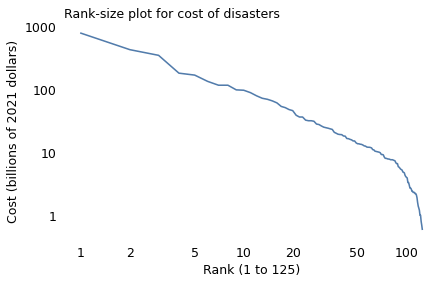

In [14]:
plt.plot(ranks, xs)
decorate(
    xlabel="Rank (1 to 125)",
    ylabel="Cost (billions of 2021 dollars)",
    xscale="log",
    yscale="log",
    title="Rank-size plot for cost of disasters",
)
xticks = [1, 2, 5, 10, 20, 50, 100]
yticks = [1, 10, 100, 1000]
plt.xticks(xticks, xticks)
plt.yticks(yticks, yticks)
plt.savefig("longtail1.png", dpi=600)

With both axes on a log scale, the rank-size plot is a nearly straight line, at least for the top 100 disasters.
And the slope of this line is close to 1, which implies that each time we double the rank, we cut the costs by one half.
That is, compared to the costliest disaster, the cost of the second-worst is one half; the cost of the fourth-worst is one quarter; the cost of the eighth is one eighth, and so on.

In [15]:
index = np.array([1, 2, 4, 8, 16, 32, 64]) - 1
steps = 10 ** mags[index]
steps /= steps[0]
1 / steps

array([ 1.        ,  1.82888836,  4.31218698,  6.70038911, 12.77658697,
       31.62857143, 74.50961538])

To visualize disaster sizes, I will show the "tail distribution", which is the complement of the cumulative distribution function (CDF).
The following figure shows the tail distribution of the 125 costliest disasters, on a log scale, along with a lognormal model.

In [16]:
from utils import make_surv, fit_truncated_normal

surv = make_surv(mags)
mu, sigma = fit_truncated_normal(surv)

[1.07816053 0.57668442]
[1.07816055 0.57668442]
[1.07816053 0.57668444]
[1.04133203 0.54825645]
[1.04133204 0.54825645]
[1.04133203 0.54825647]
[1.04293263 0.54534355]
[1.04293265 0.54534355]
[1.04293263 0.54534356]
[1.04292536 0.54517372]
[1.04292537 0.54517372]
[1.04292536 0.54517373]


In [17]:
df = pd.DataFrame(dict(surv=surv))
df.index.name = 'magnitude'
df.reset_index()

,magnitude,surv
0,-0.221849,1.000
1,-0.154902,0.992
2,-0.096910,0.984
3,0.000000,0.976
4,0.079181,0.960
...,...,...
103,2.223755,0.040
104,2.254548,0.032
105,2.537441,0.024
106,2.627058,0.016


In [18]:
df.reset_index().to_csv('disaster_magnitude.csv', index=False)
!head disaster_magnitude.csv

magnitude,surv
-0.22184874961635637,1.0
-0.1549019599857432,0.9920000000000007
-0.09691001300805639,0.9840000000000007
0.0,0.9760000000000006
0.07918124604762482,0.9600000000000006
0.11394335230683678,0.9520000000000006
0.146128035678238,0.9440000000000006
0.20411998265592482,0.9360000000000006
0.2787536009528289,0.9280000000000006


In [19]:
from utils import truncated_normal_sf

low, high = mags.min(), mags.max() * 0.99
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

In [20]:
ylabel = "Percentage with cost ≥ $x$"
xlabel = "Cost (billions of 2021 dollars)"

xlabels = [1, 10, 100, 1000]
xticks = np.log10(xlabels)

yticks = [1, 0.1, 0.01]
ylabels = ["100%", "10%", "1%"]

In [21]:
yticks = np.linspace(1, 0, 5)
ylabels = ["100%", "75%", "50%", "25%", "0%"]
yticks

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

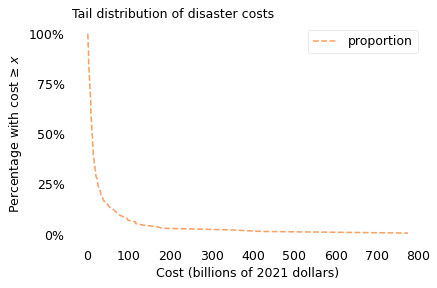

In [22]:
surv_linear = make_surv(xs)
surv_linear.plot(color="C1", ls="--")

plt.yticks(yticks, ylabels)
decorate(
    xlabel=xlabel, ylabel=ylabel, title="Tail distribution of disaster costs"
)
plt.savefig("longtail1a.png", dpi=600)

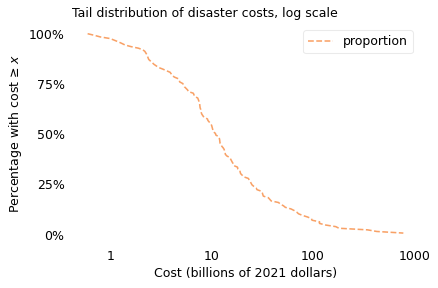

In [23]:
surv.plot(color="C1", ls="--")

plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
decorate(
    xlabel=xlabel, ylabel=ylabel, title="Tail distribution of disaster costs, log scale"
)
plt.savefig("longtail1b.png", dpi=600)

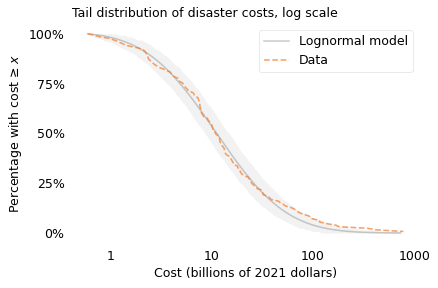

In [24]:
surv_model.plot(color="gray", alpha=0.4, label="Lognormal model")
plot_error_bounds(surv_model, n, color="gray")
surv.plot(color="C1", ls="--", label="Data")

plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
decorate(
    xlabel=xlabel, ylabel=ylabel, title="Tail distribution of disaster costs, log scale"
)
plt.savefig("longtail2.png", dpi=600)

In [25]:
surv([0, 1, 2])

array([0.976, 0.544, 0.072])

The dashed line shows the fraction of disasters that exceed each magnitude of cost.
For example, 98% of the disasters exceed a cost of $1 billion, 54% exceed $10 billion, and 7% exceed $100 billion.

The gray line shows a lognormal model I chose to fit the data; the shaded area shows how much variation we expect with a sample size of 125.
Most of the data fall within the bounds of the shaded area, which means that they are consistent with the lognormal model.

However, if you look closely, there are more large-cost disasters than we expect in a lognormal distribution.
To see this part of the distribution more clearly, we can plot the y-axis on a log scale; the following figure shows what that looks like.

In [26]:
x = np.log10(500)
y1 = surv(x)
y2 = surv_model(x)
y1 * 1e3, y2 * 1e3, y1 / y2

(15.999999999999897, 1.2081898734673209, 13.24295158515303)

In [27]:
# The Surv object doesn't interpolate, so y1 ends up too high in this example

from scipy.interpolate import interp1d

interp = interp1d(surv.index, surv.values, fill_value="extrapolate")
y1 = interp(x)

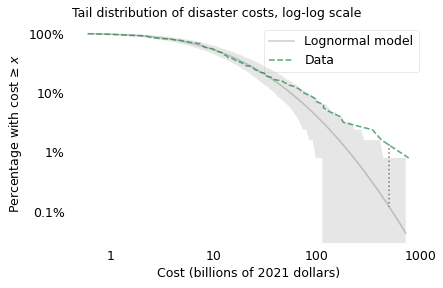

In [28]:
plt.plot([x, x], [y1, y2], ls=":", color="gray")

surv_model.plot(color="gray", alpha=0.4, label="Lognormal model")
plot_error_bounds(surv_model, n, color="gray")
surv.plot(color="C2", ls="--", label="Data")
plot_error_bounds(surv_model, n, color="gray")
plt.xticks(xticks, xlabels)
decorate(
    xlabel=xlabel,
    ylabel=ylabel,
    title="Tail distribution of disaster costs, log-log scale",
    yscale="log",
)

yticks = [1, 0.1, 0.01, 0.001]
ylabels = ["100%", "10%", "1%", "0.1%"]
plt.yticks(yticks, ylabels)
plt.savefig("longtail3.png", dpi=600)

Again, the shaded area shows how much variation we expect in a sample of this size from a lognormal model.

Now we can see more clearly where the model diverges from the data and by how much.
For example, the vertical dotted line shows the discrepancy at $500 billion.
According to the model, only 1 out of 1000 disasters should exceed this cost, but the actual rate is 16 per 1000.

To make better predictions, we need a model that accurately estimates the probability of large disasters.
In the literature of long-tailed distributions, there are several to choose from; the one I found that best matches the data is Student's $t$-distribution.

The shape of the $t$-distribution is a bell curve similar to a Gaussian, but the tails extend farther to the right and left.
It has two parameters that determine the center point and width of the curve, like the Gaussian distribution, plus a third parameter that controls the thickness of the tails, that is, what fraction of the values extend far from the mean.

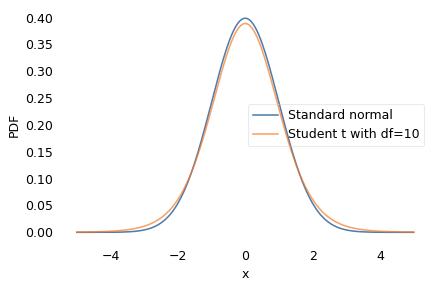

In [29]:
from scipy.stats import norm
from scipy.stats import t as t_dist

xs = np.linspace(-5, 5, 201)
ys1 = norm.pdf(xs, 0, 1)

plt.plot(xs, ys1, label='Standard normal')

df = 10
ys2 = t_dist.pdf(xs, df, 0, 1)
plt.plot(xs, ys2, label='Student t with df=10')

plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()
plt.savefig("longtail3a.png", dpi=600)

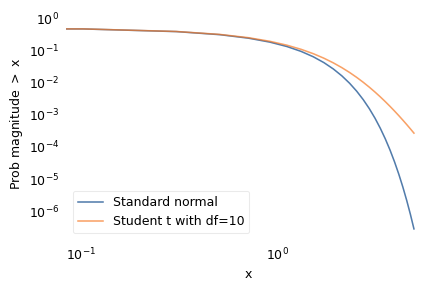

In [30]:
from scipy.stats import norm
from scipy.stats import t as t_dist

xs = np.linspace(-5, 5)
ys1 = norm.sf(xs, 0, 1)

plt.plot(xs, ys1, label='Standard normal')

ys2 = t_dist.sf(xs, df, 0, 1)
plt.plot(xs, ys2, label='Student t with df=10')

plt.xlabel('x')
plt.ylabel('Prob magnitude $>$ x')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("longtail3b.png", dpi=600)

Since I am using a $t$-distribution to fit the logarithms of the values, I'll call the result a log-$t$ model.
The following figures shows the distribution of costs again, along with a log-$t$ model I chose to fit the data.
In the top figure, the y-axis shows the fraction of disasters on a linear scale;
in the bottom figure, the y-axis shows the same fractions on a log scale.

In [31]:
from utils import minimize_df

df = minimize_df(5, surv, [(0, 20)])

In [32]:
from utils import fit_truncated_t

mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([3.52824501]), 1.0165307353889603, 0.488752041667769)

In [33]:
from utils import truncated_t_sf

low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)

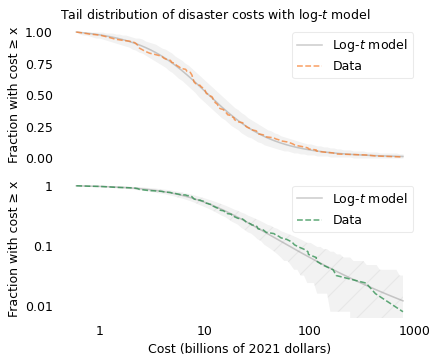

In [34]:
model_label = "Log-$t$ model"
ylabel = "Fraction with cost ≥ x"
yticks = [1, 0.1, 0.01]
ylabels = yticks
axs = plot_two(
    surv,
    surv_model2,
    n,
    hatch="/",
    title="Tail distribution of disaster costs with log-$t$ model",
)
plt.savefig("longtail4.png", dpi=600)

In the top figure, we see that the data fall within the shaded area over the entire range of the distribution.
In the bottom figure, we see that the model fits the data well even in the extreme tail.

The agreement between the model and the data provides a hint about why the distribution might have this shape.
Mathematically, Student's $t$ distribution is a mixture of Gaussian distributions with different standard deviations.

The following figure was not included in the book, but it shows that if we generate values from Gaussian distributions with different standard deviations (drawn from an inverse gamma distribution), the values follow a *t* distribution.

In [35]:
from scipy.stats import invgamma

np.random.seed(17)

a = df
sigma = np.sqrt(invgamma(a).rvs(size=125))
sigma.mean(), sigma.std()

(0.6007941329583358, 0.1717044227431617)

In [36]:
from scipy.stats import norm

mu = 1.04
sample = norm(mu, sigma).rvs()

In [37]:
surv_sample = make_surv(sample[sample > -0.4])

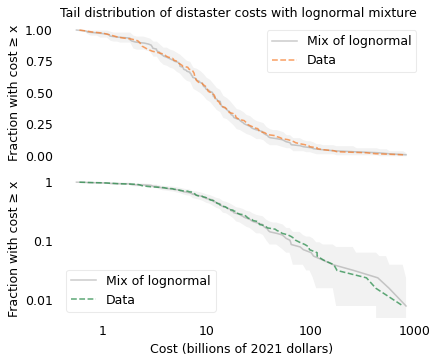

In [38]:
model_label = "Mix of lognormal"
axs = plot_two(
    surv,
    surv_sample,
    n,
    title="Tail distribution of distaster costs with lognormal mixture",
)
decorate(ylim=[5e-3, 1.1])
plt.savefig("longtail5.png", dpi=600)

## Earthquakes

To describe the magnitudes of earthquakes, I downloaded data from the Southern California Earthquake Data Center.
Their archive goes all the way back to 1932, but the sensors they use and their coverage have changed over that time.
For consistency, I selected data from January 1981 to April 2022, which includes records of 791,329 earthquakes.

For information on catalog completeness and data sources, see http://www.data.scec.org/about/data_avail.html.

In [39]:
# This version of quake.csv includes more recent data than the version in the book,
# so the results are a little different.

filename = "quake.csv"
download(DATA_PATH + filename)

In [40]:
quake_df = pd.read_csv(filename, low_memory=False)
quake_df.shape

(803451, 4)

In [41]:
quake_df.head()

,#YYY,MM,DD,MAG
0,1981,1,1,2.3
1,1981,1,1,2.3
2,1981,1,1,2.4
3,1981,1,1,1.6
4,1981,1,1,1.9


In [42]:
quake_df.tail()

,#YYY,MM,DD,MAG
803446,2022,12,31,0.5
803447,2022,12,31,1.0
803448,2022,12,31,0.9
803449,2022,12,31,0.6
803450,2022,12,31,0.6


In [43]:
year = quake_df["#YYY"] == "1989"
year.sum()

0

In [44]:
quake_df.sort_values(by="MAG").tail(10)

,#YYY,MM,DD,MAG
102346,1987,11,24,6.2
163645,1992,6,28,6.3
674787,2019,7,4,6.4
408783,2003,12,22,6.5
102647,1987,11,24,6.6
224869,1994,1,17,6.7
335296,1999,10,16,7.1
678320,2019,7,6,7.1
492576,2010,4,4,7.2
163589,1992,6,28,7.3


In [45]:
mags = quake_df["MAG"]
mags.describe()

count    803451.000000
mean          1.388616
std           0.658252
min           0.000000
25%           0.900000
50%           1.300000
75%           1.800000
max           7.300000
Name: MAG, dtype: float64

In [46]:
(mags < 2).mean()

0.8159564180018446

In [47]:
quake_df.groupby("#YYY")["MAG"].count().iloc[1:-1].describe()

count       40.000000
mean     19397.050000
std      11049.695313
min      10092.000000
25%      13467.500000
50%      16186.000000
75%      20463.000000
max      63571.000000
Name: MAG, dtype: float64

In [48]:
n = mags.count()
n

803451

In [49]:
surv = make_surv(mags)

In [50]:
mu, sigma = fit_truncated_normal(surv)

[1.48860875 0.65822228]
[1.48860877 0.65822228]
[1.48860875 0.6582223 ]
[1.37983937 0.66707222]
[1.37983939 0.66707222]
[1.37983937 0.66707224]
[1.38099766 0.65403304]
[1.38099768 0.65403304]
[1.38099766 0.65403305]
[1.38080268 0.65402889]
[1.3808027  0.65402889]
[1.38080268 0.65402891]


In [51]:
low, high = mags.min(), mags.max() * 0.99
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

The following figure shows the distribution of moment magnitudes compared to a Gaussian model, which is a lognormal model in terms of energy.

In [52]:
x = 4
y1 = surv(x)
y2 = surv_model(x)

In [53]:
xlabel = "Magnitude (log energy)"
ylabel = "Fraction with mag ≥ $x$"
xticks = np.arange(8)
xlabels = xticks
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
ylabels = [1, 0.1, 0.01, 0.001, "$10^{-4}$", "$10^{-5}$", "$10^{-6}$", "$10^{-7}$"]

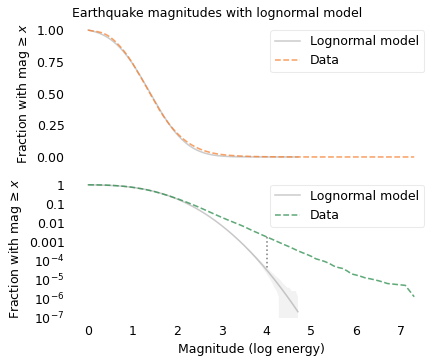

In [54]:
model_label = "Lognormal model"
cutoff = surv_model > 2e-7
axs = plot_two(
    surv,
    surv_model[cutoff],
    n,
    title="Earthquake magnitudes with lognormal model",
)
plt.plot([x, x], [y1, y2], ls=":", color="gray")

plt.tight_layout()
plt.savefig("longtail6.png", dpi=600)

If you only look at the top figure, you might think the lognormal model is good enough.
But the probabilities for magnitudes greater than 3 are so small that differences between the model and the data are not visible.

The bottom figure, with the y-axis on a log scale, shows the tail more clearly.
Here we can see that the lognormal model drops off more quickly than the data.
According to the model, the fraction of earthquakes with magnitude 4 or more should be about 33 per million.
But the actual fraction of earthquakes this big is about 1800 per million, more than 50 times higher.

For larger earthquakes, the discrepancy is even bigger.
According to the model, fewer than one earthquake in a million should exceed magnitude 5; in reality, about 170 per million do.
If your job is to predict large earthquakes, and you underestimate their frequency by a factor of 170, you are in trouble.

The following figures show the same distribution compared to a log-$t$ model.

In [55]:
y1 * 1e6, y2 * 1e6, y1 / y2

(1784.8008154824963, 31.897268299459753, 55.9546604030893)

In [56]:
x = 5
surv(x) * 1e6, surv_model(x) * 1e7

(168.02518137406247, 0.15958924021795134)

In [57]:
x = 7
surv(x) * 1e6, surv_model(x) * 1e18

# 6.318484473557436, 4.618502751454663

(6.223154865724416, 4.406280129716829)

In [58]:
df = minimize_df(10, surv, [(0, 20)])
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([9.07638598]), 1.3634555603669711, 0.6375531964799466)

In [59]:
from scipy.stats import t as t_dist

y7, y8, y9 = t_dist(df, mu, sigma).sf([7, 8, 9])

In [60]:
quakes_per_year = quake_df.groupby("#YYY")["MAG"].count().mean()
quakes_per_year

19129.785714285714

In [61]:
y522 = 1 / 522 / quakes_per_year
y522

1.0014272197675095e-07

In [62]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.1 * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)

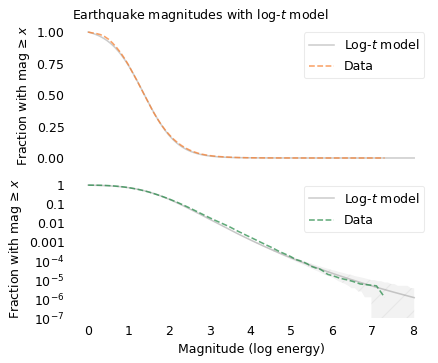

In [63]:
model_label = "Log-$t$ model"
xticks = np.arange(9)
xlabels = xticks
axs = plot_two(
    surv,
    surv_model2,
    n,
    hatch="/",
    title="Earthquake magnitudes with log-$t$ model",
)
#plt.plot(8, y8, "s", color="C0", alpha=0.6)
#plt.plot(8, y522, "o", color="C1", alpha=0.6)

plt.tight_layout()
plt.savefig("longtail7.png", dpi=600)

The top figure shows that the log-$t$ model fits the distribution well for magnitudes less than 3.
The bottom figure shows that it also fits the tail of the distribution.

If we extrapolate beyond the data, we can use this model to compute the probability of earthquakes larger than the ones we have seen so far.
For example, the square marker shows the predicted probability of an earthquake with magnitude 8, which is about 1.2 per million.

In [64]:
y8 * 1e6

1.197711963360669

In [65]:
1 / quakes_per_year / y8

43.645302435809846

The number of earthquakes in this dataset is about 18,800 per year; at that rate we should expect an earthquake that exceeds magnitude 8 every 43 years, on average.
To see how credible that expectation is, let's compare it to predictions from sources more knowledgeable than me.

In 2015, the U.S. Geological Survey (USGS) published the third revision of the Uniform California Earthquake Rupture Forecast (UCERF3).
It predicts that we should expect earthquakes in Southern California that exceed magnitude 8 at a rate of one per 522 years.
The circle marker in the figure shows the corresponding probability.

Their forecast is compatible with mine in the sense that it falls within the shaded area that represents the uncertainty of the model.
In other words, my model concedes that the predicted probability of a magnitude 8 earthquake could be off by a factor of 10, based on the data we have.
Nevertheless, if you own a building in California, or provide insurance for one, a factor of 10 is a big difference.
So you might wonder which model to believe, theirs or mine.

To find out, let's see how their predictions from 2015 have turned out so far.
For comparison, I ran the log-$t$ model again using only data from prior to 2015.
The following figure shows their predictions, mine, and the actual number of earthquakes that exceeded each magnitude in the 7.3 years between January 2015 and May 2022.

In [66]:
# https://pubs.usgs.gov/fs/2015/3009/pdf/fs2015-3009.pdf

In [67]:
prefix = quake_df["#YYY"].astype(int) < 2015
quakes_per_year = quake_df.loc[prefix].groupby("#YYY")["MAG"].count().mean()
quakes_per_year

17524.264705882353

In [68]:
mags = quake_df.loc[prefix, "MAG"]
surv = make_surv(mags)

In [69]:
df = minimize_df(10, surv, [(0, 20)])
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([8.41547484]), 1.4816444224709593, 0.6026839581707539)

In [70]:
# convert UCERF predictions to quakes per 7.33 years

pred_years = 7.33
ucerf = pred_years / pd.Series([0.24, 2.3, 12, 25, 87, 522], [5, 6, 6.7, 7, 7.5, 8])
ucerf

5.0    30.541667
6.0     3.186957
6.7     0.610833
7.0     0.293200
7.5     0.084253
8.0     0.014042
dtype: float64

In [71]:
# convert log-t predictions to quakes per 7.33 years

a = t_dist(df, mu, sigma).sf(ucerf.index) * quakes_per_year * pred_years
logt = pd.Series(a, ucerf.index)
logt

5.0    20.567019
6.0     3.414845
6.7     1.152932
7.0     0.750355
7.5     0.382366
8.0     0.204125
dtype: float64

In [72]:
# get the actual number of quakes since 2015

suffix = quake_df["#YYY"].astype(int) >= 2015
suffix.sum(), quakes_per_year * pred_years

(207626, 128452.86029411765)

In [73]:
mags = quake_df.loc[suffix, "MAG"]
actual = pd.Series(index=[5, 5.3, 5.7, 6, 6.3, 6.7, 7], dtype=float)
for thresh in actual.index:
    actual[thresh] = (mags > thresh).sum()
actual

5.0    10.0
5.3     7.0
5.7     3.0
6.0     2.0
6.3     2.0
6.7     1.0
7.0     1.0
dtype: float64

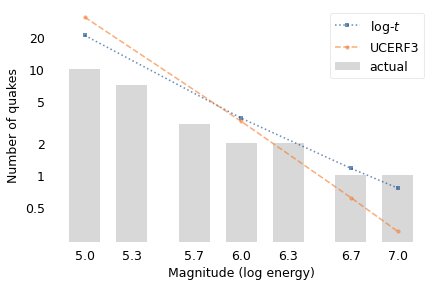

In [74]:
x = actual[:7].index
y = actual[:7].values
plt.bar(x, y, width=0.2, color="gray", alpha=0.3, label="actual")
logt[:7].plot(style="s:", alpha=0.6, label="log-$t$")
ucerf[:7].plot(style="o--", alpha=0.6, label="UCERF3")

decorate(xlabel=xlabel, ylabel="Number of quakes", yscale="log")
plt.xticks(actual[:7].index)
yticks = [20, 10, 5, 2, 1, 0.5]
ylabels = yticks
plt.yticks(yticks, yticks)

plt.tight_layout()
plt.savefig("longtail8.png", dpi=600)

Starting on the left, the UCERF model predicted that there would be 30 earthquakes in this interval with magnitude 5.0 or more.
The log-$t$ model predicted 20.
In fact, there were 10.
So there were fewer large earthquakes than either model predicted.

Near the middle of the figure, both models predicted 3 earthquakes with magnitude 6.0 or more.
In fact, there were two, so both models were close.

On the right, the UCERF model expects 0.3 earthquakes with magnitude 7.0 or more in 7.3 years.
The log-$t$ expects 0.8 earthquakes of this size in the same interval.
In fact, there was one: the main shock of the 2019 Ridgecrest earthquake sequence measured 7.1.

In [75]:
# https://en.wikipedia.org/wiki/2019_Ridgecrest_earthquakes

In [76]:
1 / (ucerf / 7.33)

5.0      0.24
6.0      2.30
6.7     12.00
7.0     25.00
7.5     87.00
8.0    522.00
dtype: float64

In [77]:
1 / (logt / 7.33)

5.0     0.356396
6.0     2.146510
6.7     6.357705
7.0     9.768712
7.5    19.170102
8.0    35.909361
dtype: float64

The discrepancy between the two models increases for larger earthquakes.
The UCERF model estimates 87 years between earthquakes that exceed 7.5; the log-$t$ model estimates only 19.
The UCERF model estimates 522 years between earthquakes that exceed 8.0; the log-$t$ model estimates only 36.

## Solar Flares

The Space Weather Prediction Center (SWPC) monitors and predicts solar activity and its effects on Earth.
Since 1974 it has operated the Geostationary Operational Environmental Satellite system (GOES).
Several of the satellites in this system carry sensors that measure solar flares.
Data from these sensors, going back to 1975, is available for download.

Since 1997, these datasets include "integrated flux" -- the kind of term science fiction writers love -- which measures the total energy from a solar flare that would pass through a given area.
The magnitude of this flux is one way to quantify its potential for impact on Earth.
This dataset includes measurements from more than 36,000 solar flares.
The following figure shows the distribution of their magnitudes compared to a lognormal model.

In [78]:
# Kurtzgesagt https://www.youtube.com/watch?v=oHHSSJDJ4oo

In [79]:
filename = "flares.csv"
download(DATA_PATH + filename)

In [80]:
flares_df = pd.read_csv(filename, header=None)
flares = flares_df[0]
flares.shape

(36560,)

In [81]:
mags = np.log10(flares)
mags.describe()

count    36560.000000
mean        -3.058657
std          0.691503
min         -5.022276
25%         -3.537602
50%         -3.080922
75%         -2.619789
max          0.414973
Name: 0, dtype: float64

In [82]:
n = mags.count()
n

36560

In [83]:
surv = make_surv(mags)

In [84]:
mu, sigma = fit_truncated_normal(surv)

[-3.04218419  0.69158557]
[-3.04218423  0.69158557]
[-3.04218419  0.69158559]
[-3.0738114   0.68338351]
[-3.07381145  0.68338351]
[-3.0738114   0.68338353]
[-3.07353797  0.68244264]
[-3.07353802  0.68244264]
[-3.07353797  0.68244265]


In [85]:
low, high = mags.min(), mags.max() * 0.99
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

In [86]:
xlabel = "Integrated flux (Joules / square meter)"
ylabel = "Fraction with flux ≥ $x$"
xticks = np.arange(-5, 1)
xlabels = ["$10^{-5}$", "$10^{-4}$", 0.001, 0.01, 0.1, 1]
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6]
ylabels = [1, 0.1, 0.01, 0.001, "$10^{-4}$", "$10^{-5}$", "$10^{-6}$"]

In [87]:
flares.max(), flares.min(), flares.max() / flares.min()

(2.6, 9.5e-06, 273684.2105263158)

In [88]:
cutoff = surv_model > 1e-6

In [89]:
x = 0
y1 = surv(x)
y2 = surv_model(x)
y1 * 1e6, y2 * 1e6, y1 / y2

(218.81838074390188, 3.3991818848706328, 64.37383704527177)

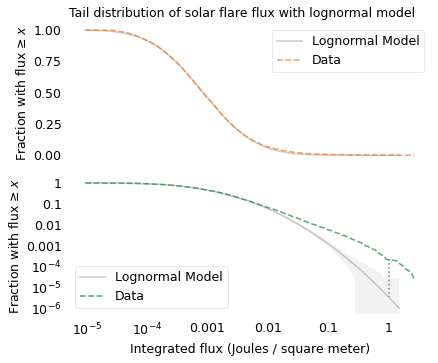

In [90]:
model_label = "Lognormal Model"
axs = plot_two(
    surv, surv_model[cutoff], n, 
    title="Tail distribution of solar flare flux with lognormal model"
)
lines = plt.plot([x, x], [y1, y2], ls=":", color="gray")

plt.tight_layout()
plt.savefig("longtail9.png", dpi=600)

The x-axis shows integrated flux on a log scale; the largest flare observed during this period measured 2.6 Joules per square meter on September 7, 2005.
By itself, that number might not mean much, but it is almost a million times bigger than the smallest flare.
So the thing to appreciate here is the great range of magnitudes.

Looking at the top figure, it seems like the lognormal model fits the data well.
But for fluxes greater than 0.1 Joules per square meter, the probabilities are so small they are indistinguishable.

Looking at the bottom figure, we can see that for fluxes in this range, the lognormal model underestimates the probabilities.
For example, according to the model, the fraction of flares with flux greater than 1 should be about 3 per million; in the dataset, it is about 200 per million.
The dotted line in the figure shows this difference.

If we are only interested in flares with flux less than 0.01, the lognormal model might be good enough.
But for predicting the effect of space weather on Earth, it is the largest flares we care about, and for those the lognormal model might be dangerously inaccurate.

Let's see if the log-$t$ model does any better.
The following figures show the distribution of fluxes again, along with a log-$t$ distribution.

In [91]:
df = minimize_df(10, surv, [(0, 20)])

In [92]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([12.38820488]), -3.0803784847994766, 0.6632850329593064)

In [93]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 3 * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)
cutoff2 = surv_model2.qs <= 1.1 * high

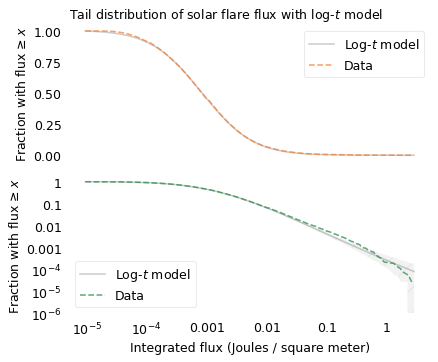

In [94]:
model_label = "Log-$t$ model"
axs = plot_two(
    surv,
    surv_model2[cutoff2],
    n,
    hatch="/",
    title="Tail distribution of solar flare flux with log-$t$ model",
)

plt.tight_layout()
plt.savefig("longtail10.png", dpi=600)

In [95]:
scale = 10
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, scale * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)
cutoff2 = surv_model2.qs <= scale * high

xticks = np.arange(-5, 5)
xlabels = ["$10^{-5}$", "$10^{-4}$", 0.001, 0.01, 0.1, 1, 10, 100, 1000, "$10^{5}$"]
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
ylabels = [1, 0.1, 0.01, 0.001, "$10^{-4}$", "$10^{-5}$", "$10^{-6}$", "$10^{-7}$"]

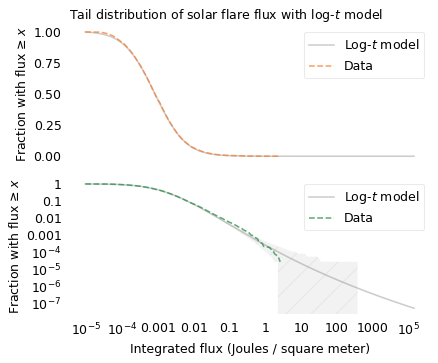

In [96]:
model_label = "Log-$t$ model"
axs = plot_two(
    surv,
    surv_model2[cutoff2],
    n,
    hatch="/",
    title="Tail distribution of solar flare flux with log-$t$ model",
)

plt.tight_layout()
plt.savefig("longtail10a.png", dpi=600)

The top figure shows that the log-$t$ model fits the data well over the range of the distribution, except for some discrepancy among the smallest flares.
Maybe we don't detect small flares as reliably, or maybe there are just fewer of them than the model predicts. 

The bottom figure shows that the model fits the tail of the distribution except possibly for the most extreme values.
Above 1 Joule per meter squared, the actual curve drops off faster than the model, although it is still within the range of variation we expect.

In [97]:
(mags > 0).sum()

7

This example shows that the distribution of the size of solar flares is longer-tailed than a lognormal distribution, which suggests that the largest possible solar flares might be substantially larger than the ones we have seen so far.

If we use the model to extrapolate beyond the data -- which is always an uncertain thing to do -- we expect 2.4 flares per million to exceed 10 Joules per square meter, and 0.36 per million to exceed 100.

In [98]:
t_dist.sf([1, 2, 3], df, mu, sigma) * 1e6, 20e6 / n

(array([21.47023593,  2.41162628,  0.35574138]), 547.0459518599563)

In [99]:
t_dist.sf(5, df, mu, sigma) * 1e9, 1e9 / 36000

(array([14.61658962]), 27777.777777777777)

In the last 20 years we have observed about 36,000 flares, so it would take more than 500 years to observe a million.
But in that time, we might see a solar flare 10 or 100 times bigger than the biggest we have seen so far.

## Lunar Craters

The largest crater on the near side of the moon, named Bailly, is 303 kilometers in diameter; the largest on the far side, the South Pole-Aitken basin, is roughly 2500 kilometers in diameter.

In addition to large, visible craters like these, there are innumerable smaller craters.
The Lunar Crater Database catalogs nearly all of the ones larger than one kilometer, about 1.3 million in total.
It is based on images taken by the Lunar Reconnaissance Orbiter, which NASA sent to the Moon in 2009.

In [100]:
# https://www.nytimes.com/2022/03/21/science/nasa-asteroid-strike.html

# https://en.wikipedia.org/wiki/Tunguska_event

In [101]:
# https://www.nasa.gov/centers/goddard/news/features/2010/biggest_crater.html
# https://en.wikipedia.org/wiki/Bailly_(crater)
# https://en.wikipedia.org/wiki/South_Pole%E2%80%93Aitken_basin

In [102]:
# https://astrogeology.usgs.gov/search/map/Moon/Research/Craters/lunar_crater_database_robbins_2018
# https://en.wikipedia.org/wiki/Lunar_Reconnaissance_Orbiter
# Robbins, S. J. (2018). A new global database of lunar impact craters >1–2 km: 1. Crater locations and sizes, comparisons with published databases, and global analysis. Journal of Geophysical Research: Planets, 124(4), pp. 871-892. https://doi.org/10.1029/2018JE005592

In [103]:
1740 * 2

3480

Download the data from https://astrogeology.usgs.gov/search/map/Moon/Research/Craters/lunar_crater_database_robbins_2018

In [104]:
download("https://pdsimage2.wr.usgs.gov/Individual_Investigations/moon_lro.kaguya_multi_craterdatabase_robbins_2018/data/lunar_crater_database_robbins_2018.csv")

In [105]:
!ls -lh lunar_crater_database_robbins_2018.csv

-rw-rw-r-- 1 downey downey 228M Mar  2  2023 lunar_crater_database_robbins_2018.csv


In [106]:
filename = "lunar_crater_database_robbins_2018.csv"
craters = pd.read_csv(filename, nrows=None)
craters.head()

,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,DIAM_CIRC_SD_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ECCEN_IMG,...,DIAM_ELLI_ANGLE_IMG,LAT_ELLI_SD_IMG,LON_ELLI_SD_IMG,DIAM_ELLI_MAJOR_SD_IMG,DIAM_ELLI_MINOR_SD_IMG,DIAM_ELLI_ANGLE_SD_IMG,DIAM_ELLI_ECCEN_SD_IMG,DIAM_ELLI_ELLIP_SD_IMG,ARC_IMG,PTS_RIM_IMG
0,00-1-000000,-19.83040,264.7570,-19.89050,264.6650,940.960,21.31790,975.874,905.968,0.371666,...,35.9919,0.007888,0.008424,0.636750,0.560417,0.373749,0.002085,0.000968,0.568712,8088
1,00-1-000001,44.77630,328.6020,44.40830,329.0460,249.840,5.99621,289.440,245.786,0.528111,...,127.0030,0.011178,0.015101,1.052780,0.209035,0.357296,0.005100,0.004399,0.627328,2785
2,00-1-000002,57.08660,82.0995,56.90000,81.6464,599.778,21.57900,632.571,561.435,0.460721,...,149.1620,0.008464,0.019515,0.776149,0.747352,0.374057,0.003095,0.002040,0.492373,5199
3,00-1-000003,1.96124,230.6220,1.95072,230.5880,558.762,14.18190,568.529,546.378,0.276416,...,133.6910,0.007079,0.007839,0.526945,0.532872,1.262710,0.004496,0.001400,0.595221,4341
4,00-1-000004,-49.14960,266.3470,-49.18330,266.3530,654.332,17.50970,665.240,636.578,0.290365,...,87.6468,0.008827,0.017733,0.568958,0.758631,1.383530,0.004626,0.001533,0.545924,5933


In [107]:
diameters = craters["DIAM_CIRC_IMG"]
diameters.describe()

count    1.296796e+06
mean     2.436963e+00
std      5.519133e+00
min      1.000000e+00
25%      1.242710e+00
50%      1.606840e+00
75%      2.380860e+00
max      2.491870e+03
Name: DIAM_CIRC_IMG, dtype: float64

In [108]:
mags = np.log10(diameters)
mags.describe()

count    1.296796e+06
mean     2.730862e-01
std      2.483783e-01
min      0.000000e+00
25%      9.436979e-02
50%      2.059726e-01
75%      3.767339e-01
max      3.396525e+00
Name: DIAM_CIRC_IMG, dtype: float64

In [109]:
n = mags.count()
n

1296796

In [110]:
surv = make_surv(mags)

In [111]:
mu, sigma = fit_truncated_normal(surv)

[0.27308865 0.24837722]
[0.27308867 0.24837722]
[0.27308865 0.24837723]
[0.05295431 0.37367805]
[0.05295432 0.37367805]
[0.05295431 0.37367806]
[-0.25451594  0.46113896]
[-0.25451595  0.46113896]
[-0.25451594  0.46113898]
[-0.34244255  0.4572347 ]
[-0.34244256  0.4572347 ]
[-0.34244255  0.45723471]
[-0.2936525   0.44014652]
[-0.29365252  0.44014652]
[-0.2936525   0.44014653]
[-0.29545249  0.44042469]
[-0.2954525   0.44042469]
[-0.29545249  0.44042471]
[-0.29531495  0.44037601]
[-0.29531496  0.44037601]
[-0.29531495  0.44037602]


In [112]:
low, high = mags.min(), mags.max() * 0.99
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

In [113]:
xlabel = "Crater diameter (kilometers)"
ylabel = "Fraction with diameter ≥ $x$"
xlabels = [1, 3, 10, 100, 1000]
xticks = np.log10(xlabels)
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-6]
ylabels = [1, 0.1, 0.01, 0.001, "$10^{-4}$", "$10^{-5}$", "$10^{-6}$", "$10^{-7}$"]

The following figures show the distribution of their sizes on a log scale, compared to a lognormal model.
The left figure shows the tail distribution on a linear scale; the right figure shows the same curve on a log scale.

In [114]:
x = 2
y1 = surv(x)
y2 = surv_model(x)
y1 * 1e6, y2 * 1e6

(242.90636307851742, 0.37897902114510834)

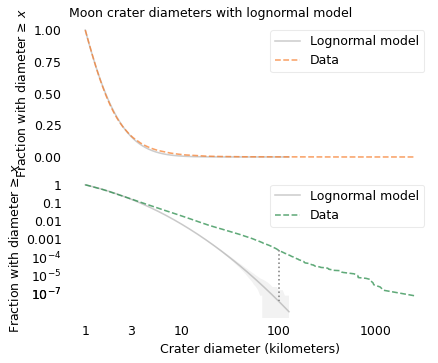

In [115]:
model_label = "Lognormal model"
cutoff = surv_model > 1e-7
axs = plot_two(
    surv, surv_model[cutoff], n, 
    title="Moon crater diameters with lognormal model"
)
plt.plot([x, x], [y1, y2], ls=":", color="gray")
plt.tight_layout()
plt.savefig("longtail11.png", dpi=600)

Looking at the figure on the left, we can see a discrepancy between the data and the model between 3 and 10 kilometers.
Nevertheless, the model fits the logarithms of the diameters well, so we could conclude that the distribution of crater sizes is approximately lognormal.

However, looking at the figure on the right, we can see big differences between the data and the model in the tail.
In the dataset, the fraction of craters as big as 100 kilometers is about 250 per million; according to the model, it would be less than 1 per million.
The dotted line in the figure shows this difference.

Going farther into the tail, the fraction of craters as big as 1000 kilometers is about 3 per million; according to the model, it would be less than one per *trillion*.
And the probability of a crater as big as the South Pole-Aitken basin is about 50 per sextillion.

If we are only interested in craters less than 10 kilometers in diameter, the lognormal model might be good enough.
But for questions related to the biggest craters, it is way off.

The following figure shows the distribution of these crater sizes, compared to a log-$t$ model.

In [116]:
y1 * 1e6, y2 * 1e6

(242.90636307851742, 0.37897902114510834)

In [117]:
x = np.log10(1000)
surv(x), surv_model(x)

(array(3.08452525e-06), array(1.46578142e-13))

In [118]:
# 50 per sextillion

norm(mu, sigma).sf(high) * 1e18

49.38523077882056

In [119]:
df = minimize_df(10, surv, [(0, 20)])

In [120]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([11.13359356]), -0.2019431517012043, 0.37469477145698354)

In [121]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.2 * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)
cutoff2 = surv_model2.qs <= 1.03 * high

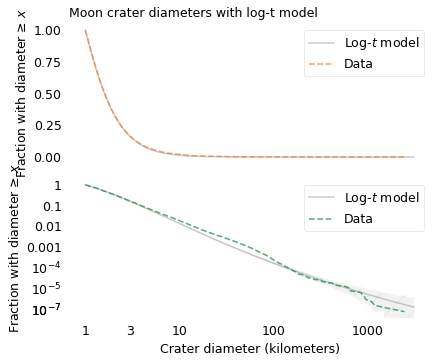

In [122]:
model_label = "Log-$t$ model"
axs = plot_two(
    surv,
    surv_model2[cutoff2],
    n,
    hatch="/",
    title="Moon crater diameters with log-t model",
)

plt.tight_layout()
plt.savefig("longtail12.png", dpi=600)

Since the dataset does not include craters smaller than one kilometer, I cut off the model at the same threshold.
We can assume that there are many smaller craters, but with this dataset we can't tell what the distribution of their sizes looks like.

The log-$t$ model fits the distribution well, but it's not perfect: there are more craters near 100 km than the model expects, and fewer craters larger than 1000 km.
As usual, the world is under no obligation to follow simple rules, but this model does pretty well.

## Asteroids

The Jet Propulsion Laboratory (JPL) and NASA provide data related to asteroids, comets and other small bodies in our solar system.
From their Small-Body Database, I selected asteroids in the "main asteroid belt" between the orbits of Mars and Jupiter.

There are more than one million asteroids in this dataset, about 136,000 with known diameter.
The largest are Ceres (940 kilometers in diameter), Vesta (525 km), Pallas (513 km), and Hygeia (407 km).
The smallest are less than one kilometer.

I downloaded the data using the [Small-Body Database](https://ssd.jpl.nasa.gov/tools/sbdb_query.html)

* Selecting Inner, outer, and main belt asteroids
* Variables: IAU name, diameter, GM (mass times gravitational constant G)

In [123]:
filename = "sbdb_query_results2.csv"
download(DATA_PATH + filename)

In [124]:
asteroids = pd.read_csv(filename, low_memory=False)
asteroids.shape

(1138975, 3)

Fans of *The Expanse* will recognize the names of the largest asteroids in [the Belt](https://expanse.fandom.com/wiki/Asteroid_Belt).

In [125]:
asteroids.dropna().sort_values(by="diameter").tail()

,name,diameter,GM
693,Interamnia,306.313,5.000000
9,Hygiea,407.120,7.000000
1,Pallas,513.000,13.630000
3,Vesta,525.400,17.288245
0,Ceres,939.400,62.628400


In [126]:
asteroids.dropna().sort_values(by="diameter").head()

,name,diameter,GM
241,Ida,32.000,0.00275
251,Mathilde,52.800,0.00689
21,Kalliope,167.536,0.49100
106,Camilla,210.370,0.74750
15,Psyche,226.000,1.53000


In [127]:
asteroids["diameter"].describe()

count    135915.000000
mean          5.265815
std           8.495350
min           0.347000
25%           2.783000
50%           3.940000
75%           5.651000
max         939.400000
Name: diameter, dtype: float64

In [128]:
mags = np.log10(asteroids["diameter"])
mags.describe()

count    135915.000000
mean          0.613943
std           0.257474
min          -0.459671
25%           0.444513
50%           0.595496
75%           0.752125
max           2.972851
Name: diameter, dtype: float64

In [129]:
n = mags.count()
n

135915

In [130]:
surv = make_surv(mags)

In [131]:
mu, sigma = fit_truncated_normal(surv)

[0.61406612 0.2574008 ]
[0.61406614 0.2574008 ]
[0.61406612 0.25740082]
[0.59649365 0.22729091]
[0.59649367 0.22729091]
[0.59649365 0.22729093]
[0.59765045 0.22862602]
[0.59765047 0.22862602]
[0.59765045 0.22862603]
[0.59766666 0.22865271]
[0.59766668 0.22865271]
[0.59766666 0.22865273]


In [132]:
from utils import truncated_normal_pmf

low, high = mags.min(), mags.max() * 0.99
qs = np.linspace(low, high, 2000)
pmf_model = truncated_normal_pmf(qs, mu, sigma)
surv_model = pmf_model.make_surv()

In [133]:
xlabel = "Asteroid diameter (kilometers)"
ylabel = "Fraction with diameter ≥ $x$"
xticks = [0, 1, 2, 3]
xlabels = [1, 10, 100, 1000]

In [134]:
x = 1.5
y1 = surv(x)
y2 = surv_model(x)
y1 * 1e6, y2 * 1e6

(8188.941617943904, 39.34458611676295)

In [135]:
cutoff = surv_model > 1e-6
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6]
ylabels = [1, 0.1, 0.01, "$10^{-3}$", "$10^{-4}$", "$10^{-5}$", "$10^{-6}$"]

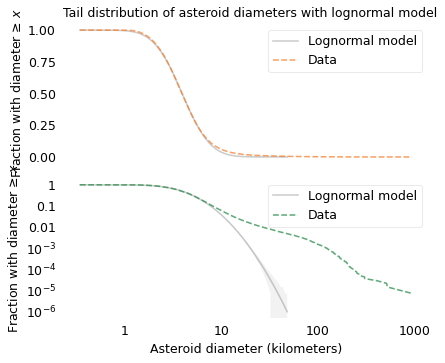

In [136]:
model_label = "Lognormal model"
axs = plot_two(
    surv,
    surv_model[cutoff],
    n,
    title="Tail distribution of asteroid diameters with lognormal model",
)
plt.tight_layout()
plt.savefig("longtail13.png", dpi=600)

The following figure shows the distribution of asteroid sizes compared to a log-$t$ model.

In [137]:
df = minimize_df(10, surv, [(0, 20)])

In [138]:
df = 6.5
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(6.5, 0.5953882516804466, 0.2150180564203059)

In [139]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.0 * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)
cutoff2 = surv_model2.qs <= 1.0 * high

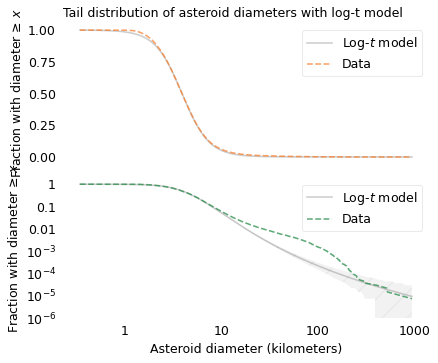

In [140]:
model_label = "Log-$t$ model"
axs = plot_two(
    surv,
    surv_model2[cutoff2],
    n,
    hatch="/",
    title="Tail distribution of asteroid diameters with log-t model",
)
plt.tight_layout()
plt.savefig("longtail14.png", dpi=600)

In the top figure, we see that the log-$t$ model fits the data well in the middle of the range, except possibly near 1 kilometer.
In the bottom, we see that the log-$t$ model does not fit the tail of the distribution particularly well: there are more asteroids near 100 km than the model predicts.
So the distribution of asteroid sizes does not strictly follow a log-$t$ distribution.
Nevertheless, we can use it to explain the distribution of crater sizes, as I'll show in the next section.

## Origins of Long-Tailed Distributions

Empirically -- that is, based on data rather than a physical model -- the diameter of an impact crater depends on the diameter of the projectile that created it, raised to the power 0.78, and on the impact velocity raised to the power 0.44.
It also depends on the density of the asteroid and the angle of impact.

Source: Melosh, *Planetary Surface Processes*.


As a simple model of this relationship, I'll simulate the crater formation process by drawing  asteroid diameters from the distribution in the previous section and drawing the other factors -- density, velocity, and angle -- from a lognormal distribution with parameters chosen to match the data.
The following figure shows the results from this simulation along with the actual distribution of crater sizes.

In [141]:
diam_asteroid = asteroids["diameter"].dropna()
diam_crater = craters["DIAM_CIRC_IMG"].dropna()
diam_asteroid.count(), diam_crater.count()

(135915, 1296796)

In [142]:
surv_crater = make_surv(np.log10(diam_crater))

In [143]:
np.random.seed(17)
n = diam_crater.count()
resample_asteroid = diam_asteroid.sample(100 * n, replace=True)
# resample_asteroid = diam_asteroid
rvs = np.random.normal(size=resample_asteroid.count())
len(rvs)

129679600

In [144]:
def error_func_pred(params):
    """Error function for finding parameters for the asteroid problem.
    
    params: tuple of mu and sigma
    
    returns: array of differences in the survival functions
    """
    print(params)
    mu, sigma = params
    factors = np.power(10, rvs * sigma + mu)
    pred_crater = factors * resample_asteroid**0.78
    mags = np.log10(pred_crater)
    cutoff = mags >= surv_crater.qs.min()
    surv_pred = make_surv(mags[cutoff])
    # surv.plot()
    # surv_pred.plot(color='gray')

    ps = np.logspace(-1, -5, 20)
    # ps = np.linspace(0.1, 0.9, 20)
    qs = surv.inverse(ps)
    # print(qs)

    error = surv_crater(qs) - surv_pred(qs)
    return error

In [145]:
mu = -3.194
sigma = 0.883
params = mu, sigma
error_func_pred(params)

(-3.194, 0.883)


array([-3.16249439e-04, -2.73415007e-05,  1.20415497e-04,  2.96512650e-04,
        4.48439739e-04,  6.12564529e-04,  4.29226980e-04,  2.16708737e-04,
        1.21459936e-04,  6.07299681e-05,  3.32894198e-05,  2.09586479e-05,
        8.46778641e-06,  8.78063634e-06,  7.08561326e-06,  1.45431455e-07,
        1.04829884e-05,  1.38803636e-05,  1.38803636e-05,  4.62678787e-06])

In [146]:
def run_minimize():
    """Find the values of mu and sigma that solve the asteroid problem.
    """
    res = least_squares(error_func_pred, x0=params, xtol=1e-3, diff_step=0.01)
    assert res.success
    mu, sigma = res.x
    return mu, sigma


# mu, sigma = run_minimize()

In [147]:
factors = np.power(10, rvs * sigma + mu)
pred_crater = factors * resample_asteroid**0.78
mags = np.log10(pred_crater)
cutoff = mags >= surv_crater.qs.min()
surv_pred = make_surv(mags[cutoff])
surv_pred.head()

,probs
diameter,
0.000001,1.000000
0.000002,0.999995
0.000005,0.999990


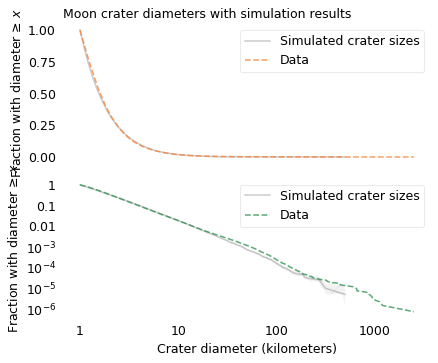

In [148]:
xlabel = "Crater diameter (kilometers)"
ylabel = "Fraction with diameter ≥ $x$"

xticks = [0, 1, 2, 3]
xlabels = [1, 10, 100, 1000]

cutoff = surv_pred.qs >= 0
model_label = "Simulated crater sizes"

axs = plot_two(
    surv_crater,
    surv_pred,
    n,
    hatch="/",
    title="Moon crater diameters with simulation results",
)

plt.tight_layout()
plt.savefig("longtail15.png", dpi=600)

The simulation results are a good match for the data.
This example suggests that the distribution of crater sizes can be explained by the relationship between the distributions of asteroid sizes and other factors like velocity and density.

## Stock Market Crashes

Like natural disasters, the distribution of magnitudes of stock market crashes is long-tailed.
To demonstrate, I'll use data from the MeasuringWorth Foundation which has compiled the value of the Dow Jones Industrial Average at the end of each day from February 16, 1885 to the present, with adjustments at several points to make the values consistent.
The series I collected ends on May 6, 2022, so it includes 37,512 days.

In [149]:
# "Citation: Samuel H. Williamson, 'Daily Closing Value of the Dow Jones Average, 1885 to Present,' MeasuringWorth, 2022. "

# https://www.measuringworth.com/datasets/DJA

In [150]:
filename = "DJA.csv"
download(DATA_PATH + filename)

In [151]:
djia = pd.read_csv(filename, skiprows=4)
djia.shape

(37512, 2)

In [152]:
djia.head()

,Date,DJIA
0,2/16/1885,30.9226
1,2/17/1885,31.3365
2,2/18/1885,31.4744
3,2/19/1885,31.6765
4,2/20/1885,31.4252


In [153]:
djia.tail()

,Date,DJIA
37507,5/2/2022,33061.50
37508,5/3/2022,33128.79
37509,5/4/2022,34061.06
37510,5/5/2022,32997.97
37511,5/6/2022,32899.37


In percentage terms, the largest single-day drop was 22.6%, during the Black Monday crash.
The second largest drop was 12.9% on March 16, 2020, during the crash caused by the COVID-19 pandemic. 
Numbers three and four on the list were 12.8% and 11.7%, on consecutive days during Wall Street Crash of 1929. 

In [154]:
diff = np.log10(djia["DJIA"]).diff()
djia["change"] = (10**diff - 1) * 100
djia.sort_values(by="change").head()

,Date,DJIA,change
28833,10/19/1987,1738.74,-22.610538
36978,3/16/2020,20188.52,-12.926547
13297,10/28/1929,260.64,-12.820684
13298,10/29/1929,230.07,-11.728821
36976,3/12/2020,21200.62,-9.988443


On the positive side, the largest single-day gain was on March 15, 1933, when the index gained 15.3%.
There were other large gains in October 1929 and October 1931.
The largest gain of the 21st century, so far, was on March 24, 2020, when the index gained 11.4% in expectation that the U.S. Congress would pass a large economic stimulus bill.

In [155]:
djia.sort_values(by="change").tail()

,Date,DJIA,change
36984,3/24/2020,20704.9100,11.365038
13299,10/30/1929,258.4700,12.344069
13871,10/6/1931,99.3400,14.870490
14292,3/15/1933,62.1000,15.341753
0,2/16/1885,30.9226,NaN


But these large moves are unusual; on 95% of days, the change is less than 2 percentage points either way.

In [156]:
djia["change"].abs().describe()

count    37511.000000
mean         0.712317
std          0.799769
min          0.000000
25%          0.217753
50%          0.493605
75%          0.935523
max         22.610538
Name: change, dtype: float64

In [157]:
(djia["change"].abs() < 2).mean()

0.9453508210705908

In [158]:
(djia["change"] < -2).mean()

0.028897419492429088

In [159]:
all_mags = np.log10(djia["DJIA"]).diff()
all_mags.describe()

count    37511.000000
mean         0.000081
std          0.004660
min         -0.111318
25%         -0.001970
50%          0.000195
75%          0.002291
max          0.061987
Name: DJIA, dtype: float64

In [160]:
(all_mags > 0).mean(), (all_mags < 0).mean(), (all_mags == 0).mean()

(0.5231392621027938, 0.4713158455960759, 0.005518234165067178)

In [161]:
r = 10 ** all_mags.mean()
(r - 1) * 100

0.018582199949923606

As an aside, the index climbed on 52.3% of days, fell on 47.1% of days, and closed exactly where it opened on the remaining 0.06% of days.
The average increase was only 0.02% per day, but with about 250 trading days per year, that amounts to an increase of 4.8% annually.
After 37,512 days, the total increase is more than 100,000%.
So that's a pretty good return on investment, if you made the investment in 1885.

In [162]:
r**250 - 1

0.04754694096007417

In [163]:
n = len(all_mags)
n, r**n - 1

(37512, 1063.1240848647278)

In [164]:
start, end = djia["DJIA"].iloc[[0, -1]]
start, end, end / start - 1

(30.9226, 32899.37, 1062.926383939255)

In [165]:
losses = all_mags < 0
losses.mean()

0.4713158455960759

In [166]:
mags = -all_mags[losses]
mags.describe()

count    1.768000e+04
mean     3.196865e-03
std      3.704198e-03
min      7.287896e-07
25%      9.450282e-04
50%      2.151678e-03
75%      4.170744e-03
max      1.113182e-01
Name: DJIA, dtype: float64

In [167]:
10 ** (-mags.max())

0.7738946206503647

In [168]:
n = mags.count()
n

17680

In [169]:
surv = make_surv(mags)

In [170]:
mu, sigma = fit_truncated_normal(surv)
mu, sigma

[0.00319705 0.00370412]
[0.00319706 0.00370412]
[0.00319705 0.00370414]
[-0.0013507   0.00550956]
[-0.00135072  0.00550956]
[-0.0013507   0.00550957]
[-0.00621391  0.00604884]
[-0.00621392  0.00604884]
[-0.00621391  0.00604886]
[-0.01126   0.007184]
[-0.01126002  0.007184  ]
[-0.01126     0.00718402]
[-0.01332923  0.00747085]
[-0.01332924  0.00747085]
[-0.01332923  0.00747086]
[-0.01298826  0.00737537]
[-0.01298827  0.00737537]
[-0.01298826  0.00737538]
[-0.01293662  0.00736386]
[-0.01293664  0.00736386]
[-0.01293662  0.00736387]
[-0.01293473  0.00736343]
[-0.01293475  0.00736343]
[-0.01293473  0.00736344]


(-0.012934732189136055, 0.007363429563516698)

In [171]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

In [172]:
xlabel = "One day percent change"
xlabels = ["no change", "-5%", "-10%", "-15%", "-20%"]
xticks = -np.log10([1, 0.95, 0.9, 0.85, 0.8])
xticks

array([-0.        ,  0.02227639,  0.04575749,  0.07058107,  0.09691001])

In [173]:
surv(xticks)[1] * 100

0.48076923076922906

In [174]:
cutoff = surv_model > 1e-5
yticks = [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5]
ylabels = [1, 0.1, 0.01, 0.001, "$10^{-4}$", "$10^{-5}$"]

Since we are interested in stock market crashes, I selected the 17,680 days when the value of the index dropped.

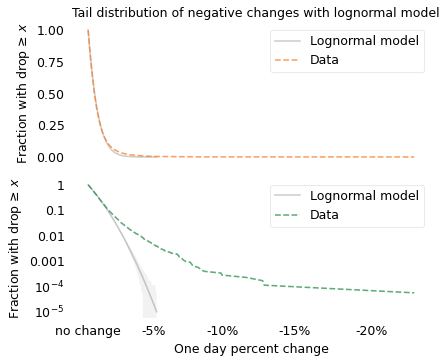

In [175]:
model_label = "Lognormal model"
ylabel = "Fraction with drop ≥ $x$"

axs = plot_two(
    surv,
    surv_model[cutoff],
    n,
    title="Tail distribution of negative changes with lognormal model",
)

plt.tight_layout()
plt.savefig("longtail16.png", dpi=600)

On the left, the lognormal model seems to fit the distribution well, but again there are big differences hiding in the tail.
On the right, we can see that the lognormal model does not fit the tail of the distribution at all.

The following figure shows the distribution of these negative percentage changes compared to a log-$t$ model.

In [176]:
df = minimize_df(3, surv, [(1, 20)])

In [177]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([3.8945931]), -0.002607418984953457, 0.003426713548607919)

In [178]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.02 * high, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)
cutoff = surv_model.qs <= high

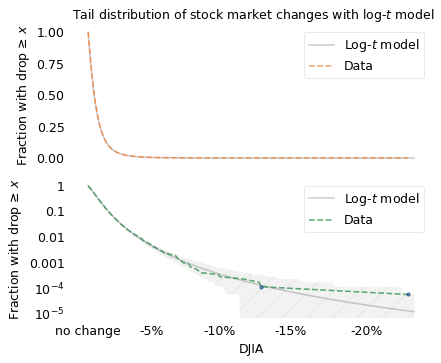

In [179]:
model_label = "Log-$t$ model"
axs = plot_two(
    surv,
    surv_model,
    n,
    hatch="/",
    title="Tail distribution of stock market changes with log-$t$ model",
)
surv.iloc[-2:].plot(color="C0", style="o")

plt.tight_layout()
plt.savefig("longtail17.png", dpi=600)

The top figure shows that the log-$t$ model fits the left side of the distribution well.
The bottom figure shows that it fits the tail well, with the possible exception of the last data point, the 1987 crash, which falls just at the edge of variation we expect.
According to the model, there is only a 5% chance that we would see a crash as big as this one after 17,680 down days.

In [180]:
x = surv.qs.max()
y1 = surv(x)
y2 = surv_model(x)
n, y1, y2, y1 / y2

(17680, array(5.6561086e-05), array(1.28916302e-05), 4.387426949065176)

In [181]:
1 - t_dist(df, mu, sigma).cdf(x) ** n

array([0.0542351])

## Black and Gray Swans

If you have read *The Black Swan*, by Nassim Taleb, the examples in this chapter provide context for understanding black swans and their relatives, gray swans.

In Taleb's vocabulary, a black swan is a large, impactful event that was considered extremely unlikely before it happened, based on a model of prior events.
If the distribution of event sizes is actually long-tailed and the model is Gaussian, black swans will happen with some regularity.

For example, if we use a Gaussian distribution to model the magnitudes of earthquakes, we predict that the probability of a magnitude 7 earthquake is about 4 per sextillion ($10^{18}$).
The actual rate in the dataset we looked at is about 6 per million, which is more likely by a factor of a trillion ($10^{12}$).
When a magnitude 7 earthquake occurs, it would be a black swan if your predictions were based on the Gaussian model.

In [182]:
# x = 7
# surv(x)*1e6, surv_model(x)*1e18

# 6.318484473557436, 4.618502751454663

## In a Long-Tailed World

Imagine a world where the distribution of human height is not Gaussian or even lognormal; instead, it follows a long-tailed distribution like the various disasters in this chapter. 
Specifically, suppose it follows a log-$t$ distribution with the same tail thickness as the distribution of disaster costs, but with the same mean as the distribution of human height.


In [183]:
filename = "brfss_sample.hdf"
download(DATA_PATH + filename)

In [184]:
brfss = pd.read_hdf(filename, "brfss")
height = brfss["HTM4"]
height.quantile([0.25, 0.75])

0.25    163.0
0.75    178.0
Name: HTM4, dtype: float64

In [185]:
mags = np.log10(height)
n = mags.count()
mags.describe()

count    375271.000000
mean          2.229956
std           0.028219
min           1.959041
25%           2.212188
50%           2.230449
75%           2.250420
max           2.369216
Name: HTM4, dtype: float64

In [186]:
surv = make_surv(mags)

In [187]:
df = minimize_df(5, surv, [(1, 1e6)])
df

array([999859.46341698])

In [188]:
df = 3.53  # same as distribution of disasters
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(3.53, 2.2293001672048596, 0.025915097488203958)

In [189]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, high, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)

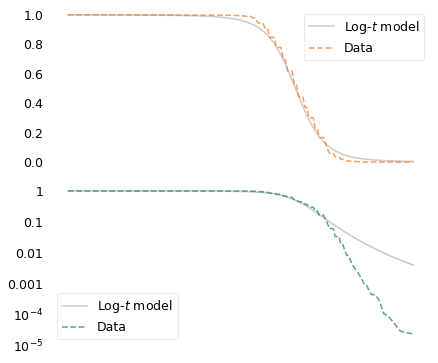

In [190]:
model_label = "Log-$t$ model"
xlabel = ""
ylabel = ""
xticks = []
xlabels = xticks
axs = plot_two(surv, surv_model, n)

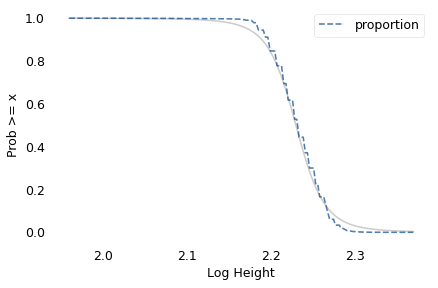

In [191]:
surv_model.plot(color="gray", alpha=0.4)
surv.plot(ls="--")
decorate(xlabel="Log Height", ylabel="Prob >= x")

In [192]:
dist = t_dist(df, mu, sigma)

In [193]:
ps = [0.9, 0.99, 0.999, 1 - 1 / 10000, 1 - 1e-6, 1 - 1 / 330e6, 1 - 1 / 7e9]
ps

[0.9, 0.99, 0.999, 0.9999, 0.999999, 0.999999996969697, 0.9999999998571428]

In [194]:
(height >= 277).mean() * 7e9

0.0

Out of 100 people, the tallest might be 215 cm.

If you see 1000 people, the tallest of them might be 277 cm.

Out of 10,000 people, the tallest would be more than 4 meters tall.

Out of a million people in Long-tailed World, the tallest would be 59 meters
.
In a country the size of the United States, the tallest person would be 160,000 kilometers tall.

And in a world population of 7 billion, the tallest would be 14 quintillion kilometers tall, which is about 1500 light years.


In [195]:
# predicted heights converted from cm to m

qs = dist.ppf(ps)
series = pd.Series(ps, 10**qs / 100)
series

1.862427e+00    0.900000
2.157498e+00    0.990000
2.770801e+00    0.999000
4.416977e+00    0.999900
5.888934e+01    0.999999
1.575737e+08    1.000000
1.445579e+19    1.000000
dtype: float64

In [196]:
# height of the tallest person in light years

series.index[-1] / 9.46073e15

1527.9783031704246

In [197]:
# double-checking that the "tallest people" examples are on the model curve

transformed = 1 - pd.Series(ps, qs)
transformed

2.270079     1.000000e-01
2.333950     1.000000e-02
2.442605     1.000000e-03
2.645125     1.000000e-04
3.770037     1.000000e-06
10.197484    3.030303e-09
21.160042    1.428572e-10
dtype: float64

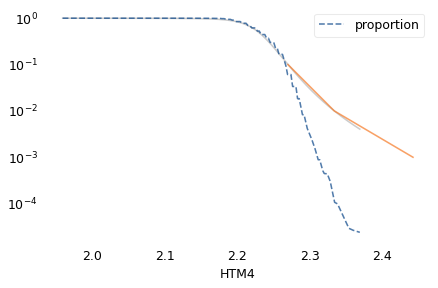

In [198]:
surv_model.plot(color="gray", alpha=0.4)
surv.plot(ls="--")
transformed.iloc[:3].plot()

decorate(yscale="log")

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).